In [1]:
# import math
# import random
# import numpy as np
# import pandas as pd
# from typing import List, Dict, Tuple, Set
# from collections import defaultdict
# import time

# # Constants
# START_TIME = 8 * 60  # 8:00 AM in minutes from midnight
# END_TIME = 20 * 60   # 8:00 PM in minutes from midnight
# COURIER_SPEED = 15.0  # km per hour
# EARTH_RADIUS = 6378.137  # km

# class Location:
#     def __init__(self, id: str, lng: float, lat: float, location_type: str):
#         self.id = id
#         self.lng = lng
#         self.lat = lat
#         self.type = location_type  # 'branch', 'poi', or 'shop'
    
#     def __str__(self):
#         return f"{self.type}:{self.id} ({self.lat}, {self.lng})"

# class Order:
#     def __init__(self, order_id: str, spot_id: str, num_packages: int):
#         self.id = order_id
#         self.spot_id = spot_id
#         self.num_packages = num_packages

# class EcommerceOrder(Order):
#     def __init__(self, order_id: str, spot_id: str, site_id: str, num_packages: int):
#         super().__init__(order_id, spot_id, num_packages)
#         self.site_id = site_id

# class O2OOrder(Order):
#     def __init__(self, order_id: str, spot_id: str, shop_id: str, pickup_time: int, delivery_time: int, num_packages: int):
#         super().__init__(order_id, spot_id, num_packages)
#         self.shop_id = shop_id
#         self.pickup_time = pickup_time  # minutes from 8:00 AM
#         self.delivery_time = delivery_time  # minutes from 8:00 AM

# class RouteStop:
#     def __init__(self, location_id: str, location_type: str, arrival_time: int, departure_time: int, 
#                  orders: List[str], packages_change: int):
#         self.location_id = location_id
#         self.location_type = location_type
#         self.arrival_time = arrival_time
#         self.departure_time = departure_time
#         self.orders = orders
#         self.packages_change = packages_change  # positive for pickup, negative for delivery

# class CourierRoute:
#     def __init__(self, courier_id: str):
#         self.courier_id = courier_id
#         self.stops = []
#         self.current_load = 0
#         self.total_travel_time = 0
#         self.total_processing_time = 0
        
#     def add_stop(self, stop: RouteStop):
#         self.stops.append(stop)
#         self.current_load += stop.packages_change
        
#     def get_total_time(self):
#         return self.total_travel_time + self.total_processing_time
    
#     def get_last_location(self):
#         if not self.stops:
#             return None
#         return self.stops[-1].location_id
    
#     def get_last_departure_time(self):
#         if not self.stops:
#             return START_TIME
#         return self.stops[-1].departure_time

# class DeliveryProblem:
#     def __init__(self):
#         self.branches = {}  # site_id -> Location
#         self.pois = {}      # spot_id -> Location
#         self.shops = {}     # shop_id -> Location
        
#         self.ecommerce_orders = []  # list of EcommerceOrder
#         self.o2o_orders = []        # list of O2OOrder
        
#         self.courier_ids = []       # list of courier_id
        
#         # Cache for distances
#         self.distance_cache = {}
        
#     def load_data(self, branch_file, poi_file, shop_file, ecommerce_file, o2o_file, courier_file):
#         # Load locations
#         branch_df = pd.read_csv(branch_file)
#         for _, row in branch_df.iterrows():
#             self.branches[row['Site_id']] = Location(row['Site_id'], row['Lng'], row['Lat'], 'branch')
            
#         poi_df = pd.read_csv(poi_file)
#         for _, row in poi_df.iterrows():
#             self.pois[row['Spot_id']] = Location(row['Spot_id'], row['Lng'], row['Lat'], 'poi')
            
#         shop_df = pd.read_csv(shop_file)
#         for _, row in shop_df.iterrows():
#             self.shops[row['Shop_id']] = Location(row['Shop_id'], row['Lng'], row['Lat'], 'shop')
            
#         # Load orders
#         ecommerce_df = pd.read_csv(ecommerce_file)
#         for _, row in ecommerce_df.iterrows():
#             self.ecommerce_orders.append(EcommerceOrder(
#                 row['Order_id'], 
#                 row['Spot_id'], 
#                 row['Site_id'], 
#                 row['Num']
#             ))
            
#         o2o_df = pd.read_csv(o2o_file)
#         for _, row in o2o_df.iterrows():
#             pickup_time = self.convert_time_to_minutes(row['Pickup_time'])
#             delivery_time = self.convert_time_to_minutes(row['Delivery_time'])
#             self.o2o_orders.append(O2OOrder(
#                 row['Order_id'], 
#                 row['Spot_id'], 
#                 row['Shop_id'], 
#                 pickup_time - START_TIME,  # convert to minutes from 8:00 AM
#                 delivery_time - START_TIME,  # convert to minutes from 8:00 AM
#                 row['Num']
#             ))
            
#         # Load courier IDs
#         courier_df = pd.read_csv(courier_file)
#         self.courier_ids = courier_df['Courier_id'].tolist()
        
#     def convert_time_to_minutes(self, time_str):
#         """Convert time string (HH:MM) to minutes from midnight"""
#         hours, minutes = map(int, time_str.split(':'))
#         return hours * 60 + minutes
        
#     def calculate_distance(self, loc1, loc2):
#         """Calculate distance between two locations using the Haversine formula"""
#         key = (loc1.id, loc2.id) if loc1.id < loc2.id else (loc2.id, loc1.id)
#         if key in self.distance_cache:
#             return self.distance_cache[key]
        
#         # Implementation of equation (1) from the problem statement
#         lat1, lng1 = math.radians(loc1.lat), math.radians(loc1.lng)
#         lat2, lng2 = math.radians(loc2.lat), math.radians(loc2.lng)
        
#         dlat = (lat1 - lat2) / 2
#         dlng = (lng1 - lng2) / 2
        
#         s = 2 * EARTH_RADIUS * math.asin(
#             math.sqrt(
#                 math.sin(dlat)**2 + 
#                 math.cos(lat1) * math.cos(lat2) * math.sin(dlng)**2
#             )
#         )
        
#         self.distance_cache[key] = s
#         return s
    
#     def calculate_travel_time(self, loc1, loc2):
#         """Calculate travel time between two locations in minutes"""
#         distance = self.calculate_distance(loc1, loc2)
#         # Convert distance (km) to time (minutes) based on speed (15 km/h)
#         return int(distance / COURIER_SPEED * 60)
    
#     def calculate_processing_time(self, num_packages):
#         """Calculate processing time at an POI based on equation (2)"""
#         return int(3 * math.sqrt(num_packages) + 5)
    
#     def get_location(self, location_id, location_type):
#         """Get location object by ID and type"""
#         if location_type == 'branch':
#             return self.branches.get(location_id)
#         elif location_type == 'poi':
#             return self.pois.get(location_id)
#         elif location_type == 'shop':
#             return self.shops.get(location_id)
#         return None

# class SimulatedAnnealing:
#     def __init__(self, problem: DeliveryProblem, initial_temp=1000, cooling_rate=0.99, min_temp=1):
#         self.problem = problem
#         self.initial_temp = initial_temp
#         self.cooling_rate = cooling_rate
#         self.min_temp = min_temp
        
#         # Group orders by branches and POIs for easier access
#         self.branch_to_orders = defaultdict(list)
#         self.poi_to_e_orders = defaultdict(list)
#         self.poi_to_o2o_orders = defaultdict(list)
        
#         for order in problem.ecommerce_orders:
#             self.branch_to_orders[order.site_id].append(order)
#             self.poi_to_e_orders[order.spot_id].append(order)
            
#         for order in problem.o2o_orders:
#             self.poi_to_o2o_orders[order.spot_id].append(order)
        
#     def generate_initial_solution(self):
#         """Generate an initial feasible solution"""
#         couriers = [CourierRoute(cid) for cid in self.problem.courier_ids[:500]]  # Start with fewer couriers
        
#         # First, assign e-commerce orders
#         assigned_e_orders = set()
#         branch_couriers = defaultdict(list)
        
#         # Group couriers by branches
#         for i, courier in enumerate(couriers):
#             # Assign courier to a branch
#             branches = list(self.problem.branches.keys())
#             branch_id = branches[i % len(branches)]
#             branch_couriers[branch_id].append(courier)
            
#             # Add initial stop at the branch
#             courier.add_stop(RouteStop(
#                 branch_id, 'branch', 0, 0, [], 0
#             ))
        
#         # Assign e-commerce orders by branch
#         for branch_id, orders in self.branch_to_orders.items():
#             if not branch_couriers[branch_id]:
#                 continue
                
#             # Sort orders by POI to minimize travel
#             orders_by_poi = defaultdict(list)
#             for order in orders:
#                 orders_by_poi[order.spot_id].append(order)
                
#             # Assign orders to couriers
#             courier_idx = 0
#             branch_courier_count = len(branch_couriers[branch_id])
            
#             for spot_id, spot_orders in orders_by_poi.items():
#                 total_packages = sum(order.num_packages for order in spot_orders)
                
#                 # Skip if already assigned
#                 if all(order.id in assigned_e_orders for order in spot_orders):
#                     continue
                    
#                 # Find courier with capacity
#                 while total_packages > 0:
#                     courier = branch_couriers[branch_id][courier_idx % branch_courier_count]
#                     courier_idx += 1
                    
#                     # Calculate how many packages this courier can take
#                     available_capacity = 140 - courier.current_load
#                     packages_to_assign = min(total_packages, available_capacity)
                    
#                     if packages_to_assign <= 0:
#                         continue
                        
#                     # Add pickup stop at branch if needed
#                     if len(courier.stops) == 1 and courier.stops[0].packages_change == 0:
#                         # Update the first stop to include package pickup
#                         orders_to_assign = []
#                         packages_assigned = 0
                        
#                         for order in spot_orders:
#                             if order.id in assigned_e_orders:
#                                 continue
                                
#                             if packages_assigned + order.num_packages <= packages_to_assign:
#                                 orders_to_assign.append(order.id)
#                                 packages_assigned += order.num_packages
#                                 assigned_e_orders.add(order.id)
                            
#                         courier.stops[0].orders = orders_to_assign
#                         courier.stops[0].packages_change = packages_assigned
#                         courier.current_load = packages_assigned
#                     else:
#                         # Create a new pickup stop at the branch
#                         branch_location = self.problem.get_location(branch_id, 'branch')
#                         last_location = self.problem.get_location(courier.get_last_location(), 
#                                                                courier.stops[-1].location_type)
#                         travel_time = self.problem.calculate_travel_time(last_location, branch_location)
                        
#                         arrival_time = courier.get_last_departure_time() + travel_time
#                         departure_time = arrival_time  # No processing time at branch
                        
#                         orders_to_assign = []
#                         packages_assigned = 0
                        
#                         for order in spot_orders:
#                             if order.id in assigned_e_orders:
#                                 continue
                                
#                             if packages_assigned + order.num_packages <= packages_to_assign:
#                                 orders_to_assign.append(order.id)
#                                 packages_assigned += order.num_packages
#                                 assigned_e_orders.add(order.id)
                        
#                         courier.add_stop(RouteStop(
#                             branch_id, 'branch', arrival_time, departure_time, 
#                             orders_to_assign, packages_assigned
#                         ))
                    
#                     # Add delivery stop at POI
#                     poi_location = self.problem.get_location(spot_id, 'poi')
#                     last_location = self.problem.get_location(courier.get_last_location(), 
#                                                            courier.stops[-1].location_type)
#                     travel_time = self.problem.calculate_travel_time(last_location, poi_location)
                    
#                     arrival_time = courier.get_last_departure_time() + travel_time
#                     processing_time = self.problem.calculate_processing_time(packages_to_assign)
#                     departure_time = arrival_time + processing_time
                    
#                     courier.add_stop(RouteStop(
#                         spot_id, 'poi', arrival_time, departure_time, 
#                         courier.stops[-1].orders, -packages_to_assign
#                     ))
                    
#                     courier.total_travel_time += travel_time
#                     courier.total_processing_time += processing_time
                    
#                     total_packages -= packages_to_assign
        
#         # Now assign O2O orders
#         assigned_o2o_orders = set()
        
#         # Sort O2O orders by pickup time
#         sorted_o2o_orders = sorted(self.problem.o2o_orders, key=lambda o: o.pickup_time)
        
#         for o2o_order in sorted_o2o_orders:
#             if o2o_order.id in assigned_o2o_orders:
#                 continue
                
#             # Find the best courier for this order
#             best_courier = None
#             best_score = float('inf')
            
#             for courier in couriers:
#                 # Check if courier can handle this order
#                 if courier.current_load + o2o_order.num_packages > 140:
#                     continue
                    
#                 # Calculate score (cost) of assigning this order
#                 shop_location = self.problem.get_location(o2o_order.shop_id, 'shop')
#                 poi_location = self.problem.get_location(o2o_order.spot_id, 'poi')
                
#                 if not courier.stops:
#                     continue
                    
#                 last_location = self.problem.get_location(courier.get_last_location(), 
#                                                        courier.stops[-1].location_type)
#                 last_time = courier.get_last_departure_time()
                
#                 # Time to reach shop
#                 time_to_shop = self.problem.calculate_travel_time(last_location, shop_location)
#                 arrival_at_shop = last_time + time_to_shop
                
#                 # Check if we can arrive before or at pickup time
#                 if arrival_at_shop > o2o_order.pickup_time:
#                     continue
                    
#                 # Calculate waiting time at shop
#                 waiting_time = max(0, o2o_order.pickup_time - arrival_at_shop)
                
#                 # Time to reach POI from shop
#                 time_to_poi = self.problem.calculate_travel_time(shop_location, poi_location)
#                 arrival_at_poi = o2o_order.pickup_time + time_to_poi
                
#                 # Check if we can deliver before or at delivery time
#                 if arrival_at_poi > o2o_order.delivery_time:
#                     continue
                
#                 # Calculate score as total added time
#                 score = time_to_shop + waiting_time + time_to_poi
                
#                 if score < best_score:
#                     best_score = score
#                     best_courier = courier
            
#             # Assign order to best courier
#             if best_courier:
#                 # Add pickup stop at shop
#                 shop_location = self.problem.get_location(o2o_order.shop_id, 'shop')
#                 last_location = self.problem.get_location(best_courier.get_last_location(), 
#                                                        best_courier.stops[-1].location_type)
#                 travel_time = self.problem.calculate_travel_time(last_location, shop_location)
                
#                 arrival_time = best_courier.get_last_departure_time() + travel_time
#                 # Wait until pickup time if arrived early
#                 departure_time = max(arrival_time, o2o_order.pickup_time)
                
#                 best_courier.add_stop(RouteStop(
#                     o2o_order.shop_id, 'shop', arrival_time, departure_time, 
#                     [o2o_order.id], o2o_order.num_packages
#                 ))
                
#                 best_courier.total_travel_time += travel_time
                
#                 # Add delivery stop at POI
#                 poi_location = self.problem.get_location(o2o_order.spot_id, 'poi')
#                 travel_time = self.problem.calculate_travel_time(shop_location, poi_location)
                
#                 arrival_time = departure_time + travel_time
#                 processing_time = self.problem.calculate_processing_time(o2o_order.num_packages)
#                 departure_time = arrival_time + processing_time
                
#                 best_courier.add_stop(RouteStop(
#                     o2o_order.spot_id, 'poi', arrival_time, departure_time, 
#                     [o2o_order.id], -o2o_order.num_packages
#                 ))
                
#                 best_courier.total_travel_time += travel_time
#                 best_courier.total_processing_time += processing_time
                
#                 assigned_o2o_orders.add(o2o_order.id)
        
#         # Filter out unused couriers
#         used_couriers = [c for c in couriers if len(c.stops) > 1]
        
#         return used_couriers
    
#     def calculate_cost(self, solution):
#         """Calculate the total cost (time) of the solution"""
#         total_time = 0
#         penalty = 0
        
#         for courier in solution:
#             # Travel and processing time
#             courier_time = courier.get_total_time()
#             total_time += courier_time
            
#             # Check for constraint violations
#             current_load = 0
#             prev_location = None
#             prev_departure = 0
            
#             for i, stop in enumerate(courier.stops):
#                 # Check capacity constraint
#                 current_load += stop.packages_change
#                 if current_load > 140 or current_load < 0:
#                     penalty += 10000  # Large penalty for capacity violation
                
#                 # Check time constraints
#                 if i > 0:
#                     location = self.problem.get_location(stop.location_id, stop.location_type)
#                     prev_loc = self.problem.get_location(prev_location, courier.stops[i-1].location_type)
                    
#                     expected_travel = self.problem.calculate_travel_time(prev_loc, location)
#                     actual_travel = stop.arrival_time - prev_departure
                    
#                     if abs(actual_travel - expected_travel) > 1:  # Allow 1 minute rounding error
#                         penalty += 10 * abs(actual_travel - expected_travel)
                
#                 # Check processing time
#                 if stop.location_type == 'poi':
#                     expected_processing = self.problem.calculate_processing_time(abs(stop.packages_change))
#                     actual_processing = stop.departure_time - stop.arrival_time
                    
#                     if abs(actual_processing - expected_processing) > 1:  # Allow 1 minute rounding error
#                         penalty += 10 * abs(actual_processing - expected_processing)
                
#                 # Check O2O constraints
#                 if stop.location_type == 'shop':
#                     for order_id in stop.orders:
#                         o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
#                         if o2o_order and stop.departure_time < o2o_order.pickup_time:
#                             penalty += 10 * (o2o_order.pickup_time - stop.departure_time)
                
#                 elif stop.location_type == 'poi':
#                     for order_id in stop.orders:
#                         o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
#                         if o2o_order and stop.arrival_time > o2o_order.delivery_time:
#                             penalty += 5 * (stop.arrival_time - o2o_order.delivery_time)
                
#                 prev_location = stop.location_id
#                 prev_departure = stop.departure_time
        
#         return total_time + penalty
    
#     def generate_neighbor(self, solution):
#         """Generate a neighboring solution by applying a random move"""
#         new_solution = [CourierRoute(c.courier_id) for c in solution]
#         for i, courier in enumerate(solution):
#             for stop in courier.stops:
#                 new_solution[i].add_stop(RouteStop(
#                     stop.location_id, stop.location_type, stop.arrival_time, 
#                     stop.departure_time, stop.orders.copy(), stop.packages_change
#                 ))
#             new_solution[i].current_load = courier.current_load
#             new_solution[i].total_travel_time = courier.total_travel_time
#             new_solution[i].total_processing_time = courier.total_processing_time
        
#         # Select a random move type
#         move_type = random.choice(['swap_stops', 'relocate_stop', 'exchange_orders'])
        
#         if move_type == 'swap_stops':
#             # Swap two consecutive stops within a route
#             if len(new_solution) < 1:
#                 return new_solution
                
#             courier_idx = random.randint(0, len(new_solution) - 1)
#             courier = new_solution[courier_idx]
            
#             if len(courier.stops) < 3:  # Need at least 3 stops for swap
#                 return new_solution
                
#             # Select two consecutive stops (not including the first branch stop)
#             stop_idx = random.randint(1, len(courier.stops) - 2)
            
#             # Don't swap if it would break pickup-delivery pairs
#             if courier.stops[stop_idx].packages_change > 0 and courier.stops[stop_idx + 1].packages_change < 0:
#                 if any(o in courier.stops[stop_idx].orders for o in courier.stops[stop_idx + 1].orders):
#                     return new_solution
            
#             # Swap the stops
#             courier.stops[stop_idx], courier.stops[stop_idx + 1] = courier.stops[stop_idx + 1], courier.stops[stop_idx]
            
#             # Recalculate times for all stops after the swap
#             self.recalculate_times(courier)
            
#         elif move_type == 'relocate_stop':
#             # Move a stop from one route to another
#             if len(new_solution) < 2:
#                 return new_solution
                
#             # Select source and destination couriers
#             source_idx = random.randint(0, len(new_solution) - 1)
#             dest_idx = random.randint(0, len(new_solution) - 1)
            
#             # Don't relocate to the same courier
#             if source_idx == dest_idx:
#                 return new_solution
                
#             source = new_solution[source_idx]
#             dest = new_solution[dest_idx]
            
#             # Don't relocate if source has only 1 or 2 stops
#             if len(source.stops) <= 2:
#                 return new_solution
                
#             # Select a stop to relocate (not the first branch stop)
#             stop_idx = random.randint(1, len(source.stops) - 1)
#             stop = source.stops[stop_idx]
            
#             # Don't relocate if it would break pickup-delivery pairs
#             if stop_idx > 0 and stop_idx < len(source.stops) - 1:
#                 if (source.stops[stop_idx - 1].packages_change > 0 and stop.packages_change < 0 and
#                     any(o in source.stops[stop_idx - 1].orders for o in stop.orders)):
#                     return new_solution
                    
#                 if (stop.packages_change > 0 and stop_idx < len(source.stops) - 1 and 
#                     source.stops[stop_idx + 1].packages_change < 0 and
#                     any(o in stop.orders for o in source.stops[stop_idx + 1].orders)):
#                     return new_solution
            
#             # Check if dest can handle the package load
#             if stop.packages_change > 0 and dest.current_load + stop.packages_change > 140:
#                 return new_solution
            
#             # Remove stop from source
#             source.stops.pop(stop_idx)
            
#             # Recalculate times for source
#             self.recalculate_times(source)
            
#             # Add stop to destination at random position (not before the first stop)
#             insert_idx = random.randint(1, len(dest.stops))
#             dest.stops.insert(insert_idx, stop)
            
#             # Recalculate times for destination
#             self.recalculate_times(dest)
            
#         elif move_type == 'exchange_orders':
#             # Exchange orders between two couriers
#             if len(new_solution) < 2:
#                 return new_solution
                
#             # Select two couriers
#             courier1_idx = random.randint(0, len(new_solution) - 1)
#             courier2_idx = random.randint(0, len(new_solution) - 1)
            
#             # Don't exchange with the same courier
#             if courier1_idx == courier2_idx:
#                 return new_solution
                
#             courier1 = new_solution[courier1_idx]
#             courier2 = new_solution[courier2_idx]
            
#             # Find pickup stops (with positive packages_change)
#             pickup_stops1 = [i for i, s in enumerate(courier1.stops) if s.packages_change > 0 and s.orders]
#             pickup_stops2 = [i for i, s in enumerate(courier2.stops) if s.packages_change > 0 and s.orders]
            
#             if not pickup_stops1 or not pickup_stops2:
#                 return new_solution
                
#             # Select random pickup stops
#             stop1_idx = random.choice(pickup_stops1)
#             stop2_idx = random.choice(pickup_stops2)
            
#             stop1 = courier1.stops[stop1_idx]
#             stop2 = courier2.stops[stop2_idx]
            
#             # Select random orders to exchange
#             if not stop1.orders or not stop2.orders:
#                 return new_solution
                
#             order1_idx = random.randint(0, len(stop1.orders) - 1)
#             order2_idx = random.randint(0, len(stop2.orders) - 1)
            
#             order1_id = stop1.orders[order1_idx]
#             order2_id = stop2.orders[order2_idx]
            
#             # Find corresponding delivery stops
#             delivery1_idx = next((i for i, s in enumerate(courier1.stops) if s.packages_change < 0 and order1_id in s.orders), None)
#             delivery2_idx = next((i for i, s in enumerate(courier2.stops) if s.packages_change < 0 and order2_id in s.orders), None)
            
#             if delivery1_idx is None or delivery2_idx is None:
#                 return new_solution
                
#             # Get order objects
#             order1 = next((o for o in self.problem.ecommerce_orders if o.id == order1_id), 
#                          next((o for o in self.problem.o2o_orders if o.id == order1_id), None))
#             order2 = next((o for o in self.problem.ecommerce_orders if o.id == order2_id), 
#                          next((o for o in self.problem.o2o_orders if o.id == order2_id), None))
            
#             if not order1 or not order2:
#                 return new_solution
                
#             # Check capacity constraints
#             new_load1 = courier1.current_load - order1.num_packages + order2.num_packages
#             new_load2 = courier2.current_load - order2.num_packages + order1.num_packages
            
#             if new_load1 > 140 or new_load2 > 140:
#                 return new_solution
                
#             # Swap orders
#             # Update pickup stops
#             stop1.orders[order1_idx] = order2_id
#             stop2.orders[order2_idx] = order1_id
            
#             # Update delivery stops
#             courier1.stops[delivery1_idx].orders.remove(order1_id)
#             courier1.stops[delivery1_idx].orders.append(order2_id)
            
#             courier2.stops[delivery2_idx].orders.remove(order2_id)
#             courier2.stops[delivery2_idx].orders.append(order1_id)
            
#             # Update package counts
#             packages_diff = order2.num_packages - order1.num_packages
            
#             courier1.stops[stop1_idx].packages_change += packages_diff
#             courier1.stops[delivery1_idx].packages_change -= packages_diff
            
#             courier2.stops[stop2_idx].packages_change -= packages_diff
#             courier2.stops[delivery2_idx].packages_change += packages_diff
            
#             courier1.current_load += packages_diff
#             courier2.current_load -= packages_diff
            
#             # Recalculate times
#             self.recalculate_times(courier1)
#             self.recalculate_times(courier2)
        
#         return new_solution
    
#     def recalculate_times(self, courier):
#         """Recalculate arrival and departure times for all stops in a route"""
#         if not courier.stops:
#             return
            
#         courier.total_travel_time = 0
#         courier.total_processing_time = 0
        
#         # First stop is typically the starting branch
#         courier.stops[0].arrival_time = START_TIME
#         courier.stops[0].departure_time = START_TIME
        
#         # Calculate times for subsequent stops
#         for i in range(1, len(courier.stops)):
#             prev_stop = courier.stops[i-1]
#             curr_stop = courier.stops[i]
            
#             # Get locations
#             prev_location = self.problem.get_location(prev_stop.location_id, prev_stop.location_type)
#             curr_location = self.problem.get_location(curr_stop.location_id, curr_stop.location_type)
            
#             # Calculate travel time
#             travel_time = self.problem.calculate_travel_time(prev_location, curr_location)
#             courier.total_travel_time += travel_time
            
#             # Calculate arrival time
#             curr_stop.arrival_time = prev_stop.departure_time + travel_time
            
#             # Calculate processing time and departure time
#             if curr_stop.location_type == 'poi':
#                 processing_time = self.problem.calculate_processing_time(abs(curr_stop.packages_change))
#                 courier.total_processing_time += processing_time
#                 curr_stop.departure_time = curr_stop.arrival_time + processing_time
#             elif curr_stop.location_type == 'shop':
#                 # For O2O orders, we might need to wait until pickup time
#                 order_id = curr_stop.orders[0] if curr_stop.orders else None
#                 if order_id:
#                     o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
#                     if o2o_order:
#                         # Wait until pickup time if necessary
#                         curr_stop.departure_time = max(curr_stop.arrival_time, o2o_order.pickup_time)
#                     else:
#                         curr_stop.departure_time = curr_stop.arrival_time
#                 else:
#                     curr_stop.departure_time = curr_stop.arrival_time
#             else:
#                 # Branch stops don't have processing time
#                 curr_stop.departure_time = curr_stop.arrival_time
    
#     def run(self, max_iterations=10000):
#         """Run the simulated annealing algorithm"""
#         print("Generating initial solution...")
#         current_solution = self.generate_initial_solution()
#         current_cost = self.calculate_cost(current_solution)
        
#         best_solution = current_solution
#         best_cost = current_cost
        
#         print(f"Initial solution: {len(current_solution)} couriers, cost = {current_cost}")
        
#         # Temperature parameters
#         temperature = self.initial_temp
        
#         # Iteration counters
#         iterations = 0
#         no_improvement = 0
        
#         print("Starting optimization...")
#         start_time = time.time()
        
#         while iterations < max_iterations and temperature > self.min_temp:
#             # Generate neighbor solution
#             neighbor_solution = self.generate_neighbor(current_solution)
#             neighbor_cost = self.calculate_cost(neighbor_solution)
            
#             # Calculate acceptance probability
#             delta = neighbor_cost - current_cost
#             acceptance_probability = 1.0 if delta < 0 else math.exp(-delta / temperature)
            
#             # Accept or reject new solution
#             if random.random() < acceptance_probability:
#                 current_solution = neighbor_solution
#                 current_cost = neighbor_cost
                
#                 # Update best solution
#                 if current_cost < best_cost:
#                     best_solution = neighbor_solution
#                     best_cost = current_cost
#                     no_improvement = 0
#                     print(f"Iteration {iterations}, temperature {temperature:.2f}: New best cost = {best_cost}")
#                 else:
#                     no_improvement += 1
#             else:
#                 no_improvement += 1
            
#             # Cool down
#             if iterations % 100 == 0:
#                 temperature *= self.cooling_rate
            
#             iterations += 1
            
#             # Early stopping if no improvement for a while
#             if no_improvement > 1000:
#                 temperature *= 0.5  # Cool down faster
#                 no_improvement = 0
            
#             # Print progress
#             if iterations % 1000 == 0:
#                 elapsed = time.time() - start_time
#                 print(f"Iteration {iterations}/{max_iterations}, temperature {temperature:.2f}, best cost = {best_cost}, elapsed time = {elapsed:.2f}s")
        
#         print(f"Optimization completed in {iterations} iterations")
#         print(f"Final solution: {len(best_solution)} couriers, cost = {best_cost}")
        
#         return best_solution

# class Route:
#     """Class to represent a final route for output"""
#     def __init__(self, courier_id):
#         self.courier_id = courier_id
#         self.stops = []
        
#     def add_stop(self, stop_id, location_type, arrival_time, departure_time, orders):
#         self.stops.append({
#             "stop_id": stop_id,
#             "location_type": location_type,
#             "arrival_time": arrival_time,
#             "departure_time": departure_time,
#             "orders": orders
#         })
        
#     def to_dict(self):
#         return {
#             "courier_id": self.courier_id,
#             "stops": self.stops
#         }

# def format_time(minutes):
#     """Format minutes from 8:00 AM to HH:MM format"""
#     total_minutes = START_TIME + minutes
#     hours = total_minutes // 60
#     minutes = total_minutes % 60
#     return f"{hours:02d}:{minutes:02d}"

# def main():
#     """Main function to run the solution"""
#     # Setup paths
#     data_dir = "raw_data/"
#     branch_file = data_dir + "branches.csv"
#     poi_file = data_dir + "pois.csv"
#     shop_file = data_dir + "shops.csv"
#     ecommerce_file = data_dir + "ecommerce_orders.csv"
#     o2o_file = data_dir + "o2o_orders.csv"
#     courier_file = data_dir + "couriers.csv"
    
#     # Load data
#     print("Loading data...")
#     problem = DeliveryProblem()
#     problem.load_data(branch_file, poi_file, shop_file, ecommerce_file, o2o_file, courier_file)
    
#     # Run simulated annealing
#     print("Starting simulated annealing optimization...")
#     sa = SimulatedAnnealing(problem)
#     solution = sa.run(max_iterations=5000)
    
#     # Prepare output
#     print("Preparing output...")
#     routes = []
    
#     for courier in solution:
#         route = Route(courier.courier_id)
        
#         for stop in courier.stops:
#             # Convert times from minutes since 8:00 AM to HH:MM format
#             arrival_time = format_time(stop.arrival_time) 
#             departure_time = format_time(stop.departure_time)
            
#             # Extract order details
#             orders = []
#             for order_id in stop.orders:
#                 # Find if it's an e-commerce or O2O order
#                 e_order = next((o for o in problem.ecommerce_orders if o.id == order_id), None)
#                 o2o_order = next((o for o in problem.o2o_orders if o.id == order_id), None)
                
#                 if e_order:
#                     orders.append({
#                         "order_id": order_id,
#                         "type": "ecommerce",
#                         "num_packages": e_order.num_packages,
#                         "action": "pickup" if stop.packages_change > 0 else "delivery"
#                     })
#                 elif o2o_order:
#                     orders.append({
#                         "order_id": order_id,
#                         "type": "o2o",
#                         "num_packages": o2o_order.num_packages,
#                         "action": "pickup" if stop.packages_change > 0 else "delivery"
#                     })
            
#             route.add_stop(
#                 stop.location_id,
#                 stop.location_type,
#                 arrival_time,
#                 departure_time,
#                 orders
#             )
        
#         routes.append(route.to_dict())
    
#     # Output to JSON
#     output_file = "solution.json"
#     import json
#     with open(output_file, 'w') as f:
#         json.dump({"routes": routes}, f, indent=2)
    
#     print(f"Solution written to {output_file}")
#     print(f"Total couriers used: {len(solution)}")
#     print(f"Total cost: {sa.calculate_cost(solution)}")

# if __name__ == "__main__":
#     main()

In [2]:
import math
import random
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Set
from collections import defaultdict
import time

In [3]:
# Constants
START_TIME = 8 * 60  # 8:00 AM in minutes from midnight
END_TIME = 20 * 60   # 8:00 PM in minutes from midnight
COURIER_SPEED = 15.0  # km per hour
EARTH_RADIUS = 6378.137  # km


In [4]:
class Location:
    def __init__(self, id: str, lng: float, lat: float, location_type: str):
        self.id = id
        self.lng = lng
        self.lat = lat
        self.type = location_type  # 'branch', 'poi', or 'shop'
    
    def __str__(self):
        return f"{self.type}:{self.id} ({self.lat}, {self.lng})"

In [5]:
class Order:
    def __init__(self, order_id: str, spot_id: str, num_packages: int):
        self.id = order_id
        self.spot_id = spot_id
        self.num_packages = num_packages

In [6]:
class EcommerceOrder(Order):
    def __init__(self, order_id: str, spot_id: str, site_id: str, num_packages: int):
        super().__init__(order_id, spot_id, num_packages)
        self.site_id = site_id

In [7]:
class O2OOrder(Order):
    def __init__(self, order_id: str, spot_id: str, shop_id: str, pickup_time: int, delivery_time: int, num_packages: int):
        super().__init__(order_id, spot_id, num_packages)
        self.shop_id = shop_id
        self.pickup_time = pickup_time  # minutes from 8:00 AM
        self.delivery_time = delivery_time  # minutes from 8:00 AM

In [8]:
class RouteStop:
    def __init__(self, location_id: str, location_type: str, arrival_time: int, departure_time: int, 
                 orders: List[str], packages_change: int):
        self.location_id = location_id
        self.location_type = location_type
        self.arrival_time = arrival_time
        self.departure_time = departure_time
        self.orders = orders
        self.packages_change = packages_change  # positive for pickup, negative for delivery


In [9]:
class CourierRoute:
    def __init__(self, courier_id: str):
        self.courier_id = courier_id
        self.stops = []
        self.current_load = 0
        self.total_travel_time = 0
        self.total_processing_time = 0
        
    def add_stop(self, stop: RouteStop):
        self.stops.append(stop)
        self.current_load += stop.packages_change
        
    def get_total_time(self):
        return self.total_travel_time + self.total_processing_time
    
    def get_last_location(self):
        if not self.stops:
            return None
        return self.stops[-1].location_id
    
    def get_last_departure_time(self):
        if not self.stops:
            return START_TIME
        return self.stops[-1].departure_time

In [10]:
class DeliveryProblem:
    def __init__(self):
        self.branches = {}  # site_id -> Location
        self.pois = {}      # spot_id -> Location
        self.shops = {}     # shop_id -> Location
        
        self.ecommerce_orders = []  # list of EcommerceOrder
        self.o2o_orders = []        # list of O2OOrder
        
        self.courier_ids = []       # list of courier_id
        
        # Cache for distances
        self.distance_cache = {}
        
    def load_data(self, branch_file, poi_file, shop_file, ecommerce_file, o2o_file, courier_file):
        # Load locations
        branch_df = pd.read_csv(branch_file)
        for _, row in branch_df.iterrows():
            self.branches[row['Site_id']] = Location(row['Site_id'], row['Lng'], row['Lat'], 'branch')
            
        poi_df = pd.read_csv(poi_file)
        for _, row in poi_df.iterrows():
            self.pois[row['Spot_id']] = Location(row['Spot_id'], row['Lng'], row['Lat'], 'poi')
            
        shop_df = pd.read_csv(shop_file)
        for _, row in shop_df.iterrows():
            self.shops[row['Shop_id']] = Location(row['Shop_id'], row['Lng'], row['Lat'], 'shop')
            
        # Load orders
        ecommerce_df = pd.read_csv(ecommerce_file)
        for _, row in ecommerce_df.iterrows():
            self.ecommerce_orders.append(EcommerceOrder(
                row['Order_id'], 
                row['Spot_id'], 
                row['Site_id'], 
                row['Num']
            ))
            
        o2o_df = pd.read_csv(o2o_file)
        for _, row in o2o_df.iterrows():
            pickup_time = self.convert_time_to_minutes(row['Pickup_time'])
            delivery_time = self.convert_time_to_minutes(row['Delivery_time'])
            self.o2o_orders.append(O2OOrder(
                row['Order_id'], 
                row['Spot_id'], 
                row['Shop_id'], 
                pickup_time - START_TIME,  # convert to minutes from 8:00 AM
                delivery_time - START_TIME,  # convert to minutes from 8:00 AM
                row['Num']
            ))
            
        # Load courier IDs
        courier_df = pd.read_csv(courier_file)
        self.courier_ids = courier_df['Courier_id'].tolist()
        
    def convert_time_to_minutes(self, time_str):
        """Convert time string (HH:MM) to minutes from midnight"""
        hours, minutes = map(int, time_str.split(':'))
        return hours * 60 + minutes
        
    def calculate_distance(self, loc1, loc2):
        """Calculate distance between two locations using the Haversine formula"""
        key = (loc1.id, loc2.id) if loc1.id < loc2.id else (loc2.id, loc1.id)
        if key in self.distance_cache:
            return self.distance_cache[key]
        
        # Implementation of equation (1) from the problem statement
        lat1, lng1 = math.radians(loc1.lat), math.radians(loc1.lng)
        lat2, lng2 = math.radians(loc2.lat), math.radians(loc2.lng)
        
        dlat = (lat1 - lat2) / 2
        dlng = (lng1 - lng2) / 2
        
        s = 2 * EARTH_RADIUS * math.asin(
            math.sqrt(
                math.sin(dlat)**2 + 
                math.cos(lat1) * math.cos(lat2) * math.sin(dlng)**2
            )
        )
        
        self.distance_cache[key] = s
        return s
    
    def calculate_travel_time(self, loc1, loc2):
        """Calculate travel time between two locations in minutes"""
        distance = self.calculate_distance(loc1, loc2)
        # Convert distance (km) to time (minutes) based on speed (15 km/h)
        return int(distance / COURIER_SPEED * 60)
    
    def calculate_processing_time(self, num_packages):
        """Calculate processing time at an POI based on equation (2)"""
        return int(3 * math.sqrt(num_packages) + 5)
    
    def get_location(self, location_id, location_type):
        """Get location object by ID and type"""
        if location_type == 'branch':
            return self.branches.get(location_id)
        elif location_type == 'poi':
            return self.pois.get(location_id)
        elif location_type == 'shop':
            return self.shops.get(location_id)
        return None

In [11]:
def load_data(self, branch_file, poi_file, shop_file, ecommerce_file, o2o_file, courier_file):
        # Load locations
        branch_df = pd.read_csv(branch_file)
        for _, row in branch_df.iterrows():
            self.branches[row['Site_id']] = Location(row['Site_id'], row['Lng'], row['Lat'], 'branch')
            
        poi_df = pd.read_csv(poi_file)
        for _, row in poi_df.iterrows():
            self.pois[row['Spot_id']] = Location(row['Spot_id'], row['Lng'], row['Lat'], 'poi')
            
        shop_df = pd.read_csv(shop_file)
        for _, row in shop_df.iterrows():
            self.shops[row['Shop_id']] = Location(row['Shop_id'], row['Lng'], row['Lat'], 'shop')
            
        # Load orders
        ecommerce_df = pd.read_csv(ecommerce_file)
        for _, row in ecommerce_df.iterrows():
            self.ecommerce_orders.append(EcommerceOrder(
                row['Order_id'], 
                row['Spot_id'], 
                row['Site_id'], 
                row['Num']
            ))
            
        o2o_df = pd.read_csv(o2o_file)
        for _, row in o2o_df.iterrows():
            pickup_time = self.convert_time_to_minutes(row['Pickup_time'])
            delivery_time = self.convert_time_to_minutes(row['Delivery_time'])
            self.o2o_orders.append(O2OOrder(
                row['Order_id'], 
                row['Spot_id'], 
                row['Shop_id'], 
                pickup_time - START_TIME,  # convert to minutes from 8:00 AM
                delivery_time - START_TIME,  # convert to minutes from 8:00 AM
                row['Num']
            ))
            
        # Load courier IDs
        courier_df = pd.read_csv(courier_file)
        self.courier_ids = courier_df['Courier_id'].tolist()

In [12]:
class SimulatedAnnealing:
    def __init__(self, problem: DeliveryProblem, initial_temp=1000, cooling_rate=0.99, min_temp=1):
        self.problem = problem
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        
        # Group orders by branches and POIs for easier access
        self.branch_to_orders = defaultdict(list)
        self.poi_to_e_orders = defaultdict(list)
        self.poi_to_o2o_orders = defaultdict(list)
        
        for order in problem.ecommerce_orders:
            self.branch_to_orders[order.site_id].append(order)
            self.poi_to_e_orders[order.spot_id].append(order)
            
        for order in problem.o2o_orders:
            self.poi_to_o2o_orders[order.spot_id].append(order)
        
    def generate_initial_solution(self):
        """Generate an initial feasible solution"""
        couriers = [CourierRoute(cid) for cid in self.problem.courier_ids[:500]]  # Start with fewer couriers
        
        # First, assign e-commerce orders
        assigned_e_orders = set()
        branch_couriers = defaultdict(list)
        
        # Group couriers by branches
        for i, courier in enumerate(couriers):
            # Assign courier to a branch
            branches = list(self.problem.branches.keys())
            branch_id = branches[i % len(branches)]
            branch_couriers[branch_id].append(courier)
            
            # Add initial stop at the branch
            courier.add_stop(RouteStop(
                branch_id, 'branch', 0, 0, [], 0
            ))
        
        # Assign e-commerce orders by branch
        for branch_id, orders in self.branch_to_orders.items():
            if not branch_couriers[branch_id]:
                continue
                
            # Sort orders by POI to minimize travel
            orders_by_poi = defaultdict(list)
            for order in orders:
                orders_by_poi[order.spot_id].append(order)
                
            # Assign orders to couriers
            courier_idx = 0
            branch_courier_count = len(branch_couriers[branch_id])
            
            for spot_id, spot_orders in orders_by_poi.items():
                total_packages = sum(order.num_packages for order in spot_orders)
                
                # Skip if already assigned
                if all(order.id in assigned_e_orders for order in spot_orders):
                    continue
                    
                # Find courier with capacity
                while total_packages > 0:
                    courier = branch_couriers[branch_id][courier_idx % branch_courier_count]
                    courier_idx += 1
                    
                    # Calculate how many packages this courier can take
                    available_capacity = 140 - courier.current_load
                    packages_to_assign = min(total_packages, available_capacity)
                    
                    if packages_to_assign <= 0:
                        continue
                        
                    # Add pickup stop at branch if needed
                    if len(courier.stops) == 1 and courier.stops[0].packages_change == 0:
                        # Update the first stop to include package pickup
                        orders_to_assign = []
                        packages_assigned = 0
                        
                        for order in spot_orders:
                            if order.id in assigned_e_orders:
                                continue
                                
                            if packages_assigned + order.num_packages <= packages_to_assign:
                                orders_to_assign.append(order.id)
                                packages_assigned += order.num_packages
                                assigned_e_orders.add(order.id)
                            
                        courier.stops[0].orders = orders_to_assign
                        courier.stops[0].packages_change = packages_assigned
                        courier.current_load = packages_assigned
                    else:
                        # Create a new pickup stop at the branch
                        branch_location = self.problem.get_location(branch_id, 'branch')
                        last_location = self.problem.get_location(courier.get_last_location(), 
                                                               courier.stops[-1].location_type)
                        travel_time = self.problem.calculate_travel_time(last_location, branch_location)
                        
                        arrival_time = courier.get_last_departure_time() + travel_time
                        departure_time = arrival_time  # No processing time at branch
                        
                        orders_to_assign = []
                        packages_assigned = 0
                        
                        for order in spot_orders:
                            if order.id in assigned_e_orders:
                                continue
                                
                            if packages_assigned + order.num_packages <= packages_to_assign:
                                orders_to_assign.append(order.id)
                                packages_assigned += order.num_packages
                                assigned_e_orders.add(order.id)
                        
                        courier.add_stop(RouteStop(
                            branch_id, 'branch', arrival_time, departure_time, 
                            orders_to_assign, packages_assigned
                        ))
                    
                    # Add delivery stop at POI
                    poi_location = self.problem.get_location(spot_id, 'poi')
                    last_location = self.problem.get_location(courier.get_last_location(), 
                                                           courier.stops[-1].location_type)
                    travel_time = self.problem.calculate_travel_time(last_location, poi_location)
                    
                    arrival_time = courier.get_last_departure_time() + travel_time
                    processing_time = self.problem.calculate_processing_time(packages_to_assign)
                    departure_time = arrival_time + processing_time
                    
                    courier.add_stop(RouteStop(
                        spot_id, 'poi', arrival_time, departure_time, 
                        courier.stops[-1].orders, -packages_to_assign
                    ))
                    
                    courier.total_travel_time += travel_time
                    courier.total_processing_time += processing_time
                    
                    total_packages -= packages_to_assign
        
        # Now assign O2O orders
        assigned_o2o_orders = set()
        
        # Sort O2O orders by pickup time
        sorted_o2o_orders = sorted(self.problem.o2o_orders, key=lambda o: o.pickup_time)
        
        for o2o_order in sorted_o2o_orders:
            if o2o_order.id in assigned_o2o_orders:
                continue
                
            # Find the best courier for this order
            best_courier = None
            best_score = float('inf')
            
            for courier in couriers:
                # Check if courier can handle this order
                if courier.current_load + o2o_order.num_packages > 140:
                    continue
                    
                # Calculate score (cost) of assigning this order
                shop_location = self.problem.get_location(o2o_order.shop_id, 'shop')
                poi_location = self.problem.get_location(o2o_order.spot_id, 'poi')
                
                if not courier.stops:
                    continue
                    
                last_location = self.problem.get_location(courier.get_last_location(), 
                                                       courier.stops[-1].location_type)
                last_time = courier.get_last_departure_time()
                
                # Time to reach shop
                time_to_shop = self.problem.calculate_travel_time(last_location, shop_location)
                arrival_at_shop = last_time + time_to_shop
                
                # Check if we can arrive before or at pickup time
                if arrival_at_shop > o2o_order.pickup_time:
                    continue
                    
                # Calculate waiting time at shop
                waiting_time = max(0, o2o_order.pickup_time - arrival_at_shop)
                
                # Time to reach POI from shop
                time_to_poi = self.problem.calculate_travel_time(shop_location, poi_location)
                arrival_at_poi = o2o_order.pickup_time + time_to_poi
                
                # Check if we can deliver before or at delivery time
                if arrival_at_poi > o2o_order.delivery_time:
                    continue
                
                # Calculate score as total added time
                score = time_to_shop + waiting_time + time_to_poi
                
                if score < best_score:
                    best_score = score
                    best_courier = courier
            
            # Assign order to best courier
            if best_courier:
                # Add pickup stop at shop
                shop_location = self.problem.get_location(o2o_order.shop_id, 'shop')
                last_location = self.problem.get_location(best_courier.get_last_location(), 
                                                       best_courier.stops[-1].location_type)
                travel_time = self.problem.calculate_travel_time(last_location, shop_location)
                
                arrival_time = best_courier.get_last_departure_time() + travel_time
                # Wait until pickup time if arrived early
                departure_time = max(arrival_time, o2o_order.pickup_time)
                
                best_courier.add_stop(RouteStop(
                    o2o_order.shop_id, 'shop', arrival_time, departure_time, 
                    [o2o_order.id], o2o_order.num_packages
                ))
                
                best_courier.total_travel_time += travel_time
                
                # Add delivery stop at POI
                poi_location = self.problem.get_location(o2o_order.spot_id, 'poi')
                travel_time = self.problem.calculate_travel_time(shop_location, poi_location)
                
                arrival_time = departure_time + travel_time
                processing_time = self.problem.calculate_processing_time(o2o_order.num_packages)
                departure_time = arrival_time + processing_time
                
                best_courier.add_stop(RouteStop(
                    o2o_order.spot_id, 'poi', arrival_time, departure_time, 
                    [o2o_order.id], -o2o_order.num_packages
                ))
                
                best_courier.total_travel_time += travel_time
                best_courier.total_processing_time += processing_time
                
                assigned_o2o_orders.add(o2o_order.id)
        
        # Filter out unused couriers
        used_couriers = [c for c in couriers if len(c.stops) > 1]
        
        return used_couriers
    
    def calculate_cost(self, solution):
        """Calculate the total cost (time) of the solution"""
        total_time = 0
        penalty = 0
        
        for courier in solution:
            # Travel and processing time
            courier_time = courier.get_total_time()
            total_time += courier_time
            
            # Check for constraint violations
            current_load = 0
            prev_location = None
            prev_departure = 0
            
            for i, stop in enumerate(courier.stops):
                # Check capacity constraint
                current_load += stop.packages_change
                if current_load > 140 or current_load < 0:
                    penalty += 10000  # Large penalty for capacity violation
                
                # Check time constraints
                if i > 0:
                    location = self.problem.get_location(stop.location_id, stop.location_type)
                    prev_loc = self.problem.get_location(prev_location, courier.stops[i-1].location_type)
                    
                    expected_travel = self.problem.calculate_travel_time(prev_loc, location)
                    actual_travel = stop.arrival_time - prev_departure
                    
                    if abs(actual_travel - expected_travel) > 1:  # Allow 1 minute rounding error
                        penalty += 10 * abs(actual_travel - expected_travel)
                
                # Check processing time
                if stop.location_type == 'poi':
                    expected_processing = self.problem.calculate_processing_time(abs(stop.packages_change))
                    actual_processing = stop.departure_time - stop.arrival_time
                    
                    if abs(actual_processing - expected_processing) > 1:  # Allow 1 minute rounding error
                        penalty += 10 * abs(actual_processing - expected_processing)
                
                # Check O2O constraints
                if stop.location_type == 'shop':
                    for order_id in stop.orders:
                        o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
                        if o2o_order and stop.departure_time < o2o_order.pickup_time:
                            penalty += 10 * (o2o_order.pickup_time - stop.departure_time)
                
                elif stop.location_type == 'poi':
                    for order_id in stop.orders:
                        o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
                        if o2o_order and stop.arrival_time > o2o_order.delivery_time:
                            penalty += 5 * (stop.arrival_time - o2o_order.delivery_time)
                
                prev_location = stop.location_id
                prev_departure = stop.departure_time
        
        return total_time + penalty
    
    def generate_neighbor(self, solution):
        """Generate a neighboring solution with improved diversification"""
        new_solution = [CourierRoute(c.courier_id) for c in solution]
        for i, courier in enumerate(solution):
            for stop in courier.stops:
                new_solution[i].add_stop(RouteStop(
                    stop.location_id, stop.location_type, stop.arrival_time, 
                    stop.departure_time, stop.orders.copy(), stop.packages_change
                ))
            new_solution[i].current_load = courier.current_load
            new_solution[i].total_travel_time = courier.total_travel_time
            new_solution[i].total_processing_time = courier.total_processing_time
        
        # Increase diversity by using more aggressive moves occasionally
        diversification = random.random() < 0.3
        
        # Select a move type with different probabilities
        move_type_probs = [0.4, 0.4, 0.2]  # Adjust these probabilities as needed
        move_type = random.choices(['swap_stops', 'relocate_stop', 'exchange_orders'], 
                                  weights=move_type_probs)[0]
        
        if move_type == 'swap_stops':
            # Enhanced swap stops strategy
            if len(new_solution) < 1:
                return new_solution
                
            # Try multiple couriers to find a viable swap
            attempt_count = 0
            max_attempts = 5
            
            while attempt_count < max_attempts:
                courier_idx = random.randint(0, len(new_solution) - 1)
                courier = new_solution[courier_idx]
                
                if len(courier.stops) < 3:  # Need at least 3 stops for swap
                    attempt_count += 1
                    continue
                    
                # Select two consecutive stops (not including the first branch stop)
                stop_idx = random.randint(1, len(courier.stops) - 2)
                
                # Allow more disruptive swaps during diversification
                if diversification:
                    # Try to swap non-consecutive stops
                    second_idx = random.randint(1, len(courier.stops) - 1)
                    while second_idx == stop_idx or second_idx == stop_idx + 1:
                        second_idx = random.randint(1, len(courier.stops) - 1)
                    
                    # Don't swap if it would break pickup-delivery pairs
                    valid_swap = True
                    for order_id in courier.stops[stop_idx].orders:
                        for i, stop in enumerate(courier.stops):
                            if i != stop_idx and order_id in stop.orders:
                                if (stop_idx < i < second_idx) or (second_idx < i < stop_idx):
                                    valid_swap = False
                                    break
                                
                    if valid_swap:
                        courier.stops[stop_idx], courier.stops[second_idx] = courier.stops[second_idx], courier.stops[stop_idx]
                        self.recalculate_times(courier)
                        return new_solution
                else:
                    # Standard swap of consecutive stops
                    if courier.stops[stop_idx].packages_change > 0 and courier.stops[stop_idx + 1].packages_change < 0:
                        if any(o in courier.stops[stop_idx].orders for o in courier.stops[stop_idx + 1].orders):
                            attempt_count += 1
                            continue
                        
                    # Swap the stops
                    courier.stops[stop_idx], courier.stops[stop_idx + 1] = courier.stops[stop_idx + 1], courier.stops[stop_idx]
                    self.recalculate_times(courier)
                    return new_solution
                    
                attempt_count += 1
            
        elif move_type == 'relocate_stop':
            # Enhanced relocate stop strategy
            if len(new_solution) < 2:
                return new_solution
            
            # Try multiple relocations to find a viable one
            attempt_count = 0
            max_attempts = 5
            
            while attempt_count < max_attempts:
                # Select source and destination couriers
                source_idx = random.randint(0, len(new_solution) - 1)
                
                # During diversification, try to balance loads between couriers
                if diversification:
                    # Find a heavily loaded courier as source
                    candidates = [(i, c) for i, c in enumerate(new_solution) 
                                 if len(c.stops) > 3]
                    if candidates:
                        candidates.sort(key=lambda x: len(x[1].stops), reverse=True)
                        source_idx = candidates[0][0]
                
                dest_idx = random.randint(0, len(new_solution) - 1)
                
                # Don't relocate to the same courier
                if source_idx == dest_idx:
                    attempt_count += 1
                    continue
                    
                source = new_solution[source_idx]
                dest = new_solution[dest_idx]
                
                # Don't relocate if source has only 1 or 2 stops
                if len(source.stops) <= 2:
                    attempt_count += 1
                    continue
                    
                # Select a stop to relocate (not the first branch stop)
                # During diversification, try to relocate chains of stops together
                if diversification and len(source.stops) > 4:
                    # Try to relocate a pair of stops
                    stop_idx = random.randint(1, len(source.stops) - 2)
                    
                    # Check if we can relocate two consecutive stops
                    stop1 = source.stops[stop_idx]
                    stop2 = source.stops[stop_idx + 1]
                    
                    # Check if destination can handle both stops
                    if (stop1.packages_change + stop2.packages_change > 0 and 
                        dest.current_load + stop1.packages_change + stop2.packages_change <= 140):
                        
                        # Remove stops from source
                        removed_stops = [source.stops.pop(stop_idx), source.stops.pop(stop_idx)]
                        source.current_load -= (stop1.packages_change + stop2.packages_change)
                        
                        # Recalculate times for source
                        self.recalculate_times(source)
                        
                        # Add stops to destination at random position
                        insert_idx = random.randint(1, len(dest.stops))
                        dest.stops[insert_idx:insert_idx] = removed_stops
                        dest.current_load += (stop1.packages_change + stop2.packages_change)
                        
                        # Recalculate times for destination
                        self.recalculate_times(dest)
                        return new_solution
                
                # Standard single stop relocation
                stop_idx = random.randint(1, len(source.stops) - 1)
                stop = source.stops[stop_idx]
                
                # Don't relocate if it would break pickup-delivery pairs
                valid_relocation = True
                for order_id in stop.orders:
                    # Check if this order has related stops in the same route
                    for i, other_stop in enumerate(source.stops):
                        if i != stop_idx and order_id in other_stop.orders:
                            valid_relocation = False
                            break
                        
                if not valid_relocation:
                    attempt_count += 1
                    continue
                    
                # Check if dest can handle the package load
                if stop.packages_change > 0 and dest.current_load + stop.packages_change > 140:
                    attempt_count += 1
                    continue
                
                # Remove stop from source
                source.stops.pop(stop_idx)
                source.current_load -= stop.packages_change
                
                # Recalculate times for source
                self.recalculate_times(source)
                
                # Add stop to destination at random position (not before the first stop)
                insert_idx = random.randint(1, len(dest.stops))
                dest.stops.insert(insert_idx, stop)
                dest.current_load += stop.packages_change
                
                # Recalculate times for destination
                self.recalculate_times(dest)
                return new_solution
                
                attempt_count += 1
                
        elif move_type == 'exchange_orders':
            # Enhanced exchange orders strategy
            if len(new_solution) < 2:
                return new_solution
            
            # Try multiple courier pairs
            attempt_count = 0
            max_attempts = 5
            
            while attempt_count < max_attempts:
                # Select two couriers
                courier1_idx = random.randint(0, len(new_solution) - 1)
                courier2_idx = random.randint(0, len(new_solution) - 1)
                
                # Don't exchange with the same courier
                if courier1_idx == courier2_idx:
                    attempt_count += 1
                    continue
                    
                courier1 = new_solution[courier1_idx]
                courier2 = new_solution[courier2_idx]
                
                # Find pickup stops (with positive packages_change)
                pickup_stops1 = [i for i, s in enumerate(courier1.stops) if s.packages_change > 0 and s.orders]
                pickup_stops2 = [i for i, s in enumerate(courier2.stops) if s.packages_change > 0 and s.orders]
                
                if not pickup_stops1 or not pickup_stops2:
                    attempt_count += 1
                    continue
                    
                # Select random pickup stops
                stop1_idx = random.choice(pickup_stops1)
                stop2_idx = random.choice(pickup_stops2)
                
                stop1 = courier1.stops[stop1_idx]
                stop2 = courier2.stops[stop2_idx]
                
                # During diversification, try to exchange complete pickup-delivery pairs
                if diversification and len(stop1.orders) > 0 and len(stop2.orders) > 0:
                    order1_id = random.choice(stop1.orders)
                    order2_id = random.choice(stop2.orders)
                    
                    # Find all stops related to these orders
                    courier1_stops = [(i, s) for i, s in enumerate(courier1.stops) if order1_id in s.orders]
                    courier2_stops = [(i, s) for i, s in enumerate(courier2.stops) if order2_id in s.orders]
                    
                    if len(courier1_stops) == 2 and len(courier2_stops) == 2:
                        # Get the order objects
                        order1 = next((o for o in self.problem.ecommerce_orders if o.id == order1_id), 
                                    next((o for o in self.problem.o2o_orders if o.id == order1_id), None))
                        order2 = next((o for o in self.problem.ecommerce_orders if o.id == order2_id), 
                                    next((o for o in self.problem.o2o_orders if o.id == order2_id), None))
                        
                        if order1 and order2:
                            # Check capacity constraints
                            new_load1 = courier1.current_load - order1.num_packages + order2.num_packages
                            new_load2 = courier2.current_load - order2.num_packages + order1.num_packages
                            
                            if new_load1 <= 140 and new_load2 <= 140:
                                # Exchange the orders in all related stops
                                for idx, stop in courier1_stops:
                                    stop.orders.remove(order1_id)
                                    stop.orders.append(order2_id)
                                    if idx == courier1_stops[0][0]:  # Pickup stop
                                        stop.packages_change = stop.packages_change - order1.num_packages + order2.num_packages
                                    else:  # Delivery stop
                                        stop.packages_change = stop.packages_change + order1.num_packages - order2.num_packages
                                
                                for idx, stop in courier2_stops:
                                    stop.orders.remove(order2_id)
                                    stop.orders.append(order1_id)
                                    if idx == courier2_stops[0][0]:  # Pickup stop
                                        stop.packages_change = stop.packages_change - order2.num_packages + order1.num_packages
                                    else:  # Delivery stop
                                        stop.packages_change = stop.packages_change + order2.num_packages - order1.num_packages
                                
                                courier1.current_load = new_load1
                                courier2.current_load = new_load2
                                
                                # Recalculate times
                                self.recalculate_times(courier1)
                                self.recalculate_times(courier2)
                                return new_solution
                
                # Standard order exchange
                if not stop1.orders or not stop2.orders:
                    attempt_count += 1
                    continue
                    
                order1_idx = random.randint(0, len(stop1.orders) - 1)
                order2_idx = random.randint(0, len(stop2.orders) - 1)
                
                order1_id = stop1.orders[order1_idx]
                order2_id = stop2.orders[order2_idx]
                
                # Find corresponding delivery stops
                delivery1_idx = next((i for i, s in enumerate(courier1.stops) if s.packages_change < 0 and order1_id in s.orders), None)
                delivery2_idx = next((i for i, s in enumerate(courier2.stops) if s.packages_change < 0 and order2_id in s.orders), None)
                
                if delivery1_idx is None or delivery2_idx is None:
                    attempt_count += 1
                    continue
                    
                # Get order objects
                order1 = next((o for o in self.problem.ecommerce_orders if o.id == order1_id), 
                             next((o for o in self.problem.o2o_orders if o.id == order1_id), None))
                order2 = next((o for o in self.problem.ecommerce_orders if o.id == order2_id), 
                             next((o for o in self.problem.o2o_orders if o.id == order2_id), None))
                
                if not order1 or not order2:
                    attempt_count += 1
                    continue
                    
                # Check capacity constraints
                new_load1 = courier1.current_load - order1.num_packages + order2.num_packages
                new_load2 = courier2.current_load - order2.num_packages + order1.num_packages
                
                if new_load1 > 140 or new_load2 > 140:
                    attempt_count += 1
                    continue
                    
                # Swap orders
                # Update pickup stops
                stop1.orders[order1_idx] = order2_id
                stop2.orders[order2_idx] = order1_id
                
                # Update delivery stops
                courier1.stops[delivery1_idx].orders.remove(order1_id)
                courier1.stops[delivery1_idx].orders.append(order2_id)
                
                courier2.stops[delivery2_idx].orders.remove(order2_id)
                courier2.stops[delivery2_idx].orders.append(order1_id)
                
                # Update package counts
                packages_diff = order2.num_packages - order1.num_packages
                
                courier1.stops[stop1_idx].packages_change += packages_diff
                courier1.stops[delivery1_idx].packages_change -= packages_diff
                
                courier2.stops[stop2_idx].packages_change -= packages_diff
                courier2.stops[delivery2_idx].packages_change += packages_diff
                
                courier1.current_load += packages_diff
                courier2.current_load -= packages_diff
                
                # Recalculate times
                self.recalculate_times(courier1)
                self.recalculate_times(courier2)
                return new_solution
                
                attempt_count += 1
        
        # If all attempts failed, return the unmodified solution
        return new_solution

    def recalculate_times(self, courier):
        """Recalculate arrival and departure times for all stops in a route"""
        if not courier.stops:
            return
            
        courier.total_travel_time = 0
        courier.total_processing_time = 0
        
        # First stop is typically the starting branch
        courier.stops[0].arrival_time = START_TIME
        courier.stops[0].departure_time = START_TIME
        
        # Calculate times for subsequent stops
        for i in range(1, len(courier.stops)):
            prev_stop = courier.stops[i-1]
            curr_stop = courier.stops[i]
            
            # Get locations
            prev_location = self.problem.get_location(prev_stop.location_id, prev_stop.location_type)
            curr_location = self.problem.get_location(curr_stop.location_id, curr_stop.location_type)
            
            # Calculate travel time
            travel_time = self.problem.calculate_travel_time(prev_location, curr_location)
            courier.total_travel_time += travel_time
            
            # Calculate arrival time
            curr_stop.arrival_time = prev_stop.departure_time + travel_time
            
            # Calculate processing time and departure time
            if curr_stop.location_type == 'poi':
                processing_time = self.problem.calculate_processing_time(abs(curr_stop.packages_change))
                courier.total_processing_time += processing_time
                curr_stop.departure_time = curr_stop.arrival_time + processing_time
            elif curr_stop.location_type == 'shop':
                # For O2O orders, we might need to wait until pickup time
                order_id = curr_stop.orders[0] if curr_stop.orders else None
                if order_id:
                    o2o_order = next((o for o in self.problem.o2o_orders if o.id == order_id), None)
                    if o2o_order:
                        # Wait until pickup time if necessary
                        curr_stop.departure_time = max(curr_stop.arrival_time, o2o_order.pickup_time)
                    else:
                        curr_stop.departure_time = curr_stop.arrival_time
                else:
                    curr_stop.departure_time = curr_stop.arrival_time
            else:
                # Branch stops don't have processing time
                curr_stop.departure_time = curr_stop.arrival_time
    
    def run(self, max_iterations=10000):
        """Run the simulated annealing algorithm with improved parameters"""
        print("Generating initial solution...")
        current_solution = self.generate_initial_solution()
        current_cost = self.calculate_cost(current_solution)
        
        best_solution = [CourierRoute(c.courier_id) for c in current_solution]
        for i, courier in enumerate(current_solution):
            for stop in courier.stops:
                best_solution[i].add_stop(RouteStop(
                    stop.location_id, stop.location_type, stop.arrival_time, 
                    stop.departure_time, stop.orders.copy(), stop.packages_change
                ))
            best_solution[i].current_load = courier.current_load
            best_solution[i].total_travel_time = courier.total_travel_time
            best_solution[i].total_processing_time = courier.total_processing_time
        
        best_cost = current_cost
        
        print(f"Initial solution: {len(current_solution)} couriers, cost = {current_cost}")
        
        # Improved temperature parameters
        temperature = self.initial_temp * 5  # Start with higher temperature
        cooling_rate = 0.995  # Slower cooling
        reheat_threshold = 2000  # Reheat after this many iterations without improvement
        
        # Iteration counters
        iterations = 0
        no_improvement = 0
        
        # Statistics
        accepted_moves = 0
        rejected_moves = 0
        
        print("Starting optimization...")
        start_time = time.time()
        
        while iterations < max_iterations and temperature > self.min_temp:
            # Generate neighbor solution
            neighbor_solution = self.generate_neighbor(current_solution)
            neighbor_cost = self.calculate_cost(neighbor_solution)
            
            # Calculate acceptance probability
            delta = neighbor_cost - current_cost
            
            # Use a more aggressive acceptance probability function
            if delta < 0:  # Always accept better solutions
                acceptance_probability = 1.0
            else:
                # Adjust this exponent to control acceptance rate
                acceptance_probability = math.exp(-delta / (temperature * 1.5))
            
            # Accept or reject new solution
            if random.random() < acceptance_probability:
                current_solution = neighbor_solution
                current_cost = neighbor_cost
                accepted_moves += 1
                
                # Update best solution
                if current_cost < best_cost:
                    # Deep copy the solution
                    best_solution = [CourierRoute(c.courier_id) for c in current_solution]
                    for i, courier in enumerate(current_solution):
                        for stop in courier.stops:
                            best_solution[i].add_stop(RouteStop(
                                stop.location_id, stop.location_type, stop.arrival_time, 
                                stop.departure_time, stop.orders.copy(), stop.packages_change
                            ))
                        best_solution[i].current_load = courier.current_load
                        best_solution[i].total_travel_time = courier.total_travel_time
                        best_solution[i].total_processing_time = courier.total_processing_time
                    
                    best_cost = current_cost
                    no_improvement = 0
                    print(f"Iteration {iterations}, temperature {temperature:.2f}: New best cost = {best_cost}")
                else:
                    no_improvement += 1
            else:
                rejected_moves += 1
                no_improvement += 1
            
            # Cooling schedule
            if iterations % 100 == 0:
                temperature *= cooling_rate
            
            iterations += 1
            
            # Reheat if stuck in local optimum
            if no_improvement >= reheat_threshold:
                old_temp = temperature
                temperature = temperature * 3  # Reheat to escape local optima
                print(f"Reheating temperature from {old_temp:.2f} to {temperature:.2f} after {no_improvement} iterations without improvement")
                no_improvement = 0
            
            # Print progress with additional statistics
            if iterations % 500 == 0:
                elapsed = time.time() - start_time
                acceptance_rate = accepted_moves / (accepted_moves + rejected_moves) * 100 if accepted_moves + rejected_moves > 0 else 0
                print(f"Iteration {iterations}/{max_iterations}, temperature {temperature:.2f}, best cost = {best_cost}, current cost = {current_cost}")
                print(f"Elapsed time = {elapsed:.2f}s, acceptance rate = {acceptance_rate:.2f}%")
                # Reset counters
                accepted_moves = 0
                rejected_moves = 0
        
        print(f"Optimization completed in {iterations} iterations")
        print(f"Final solution: {len(best_solution)} couriers, cost = {best_cost}")
        
        return best_solution


In [13]:
class Route:
    """Class to represent a final route for output"""
    def __init__(self, courier_id):
        self.courier_id = courier_id
        self.stops = []
        
    def add_stop(self, stop_id, location_type, arrival_time, departure_time, orders):
        self.stops.append({
            "stop_id": stop_id,
            "location_type": location_type,
            "arrival_time": arrival_time,
            "departure_time": departure_time,
            "orders": orders
        })
        
    def to_dict(self):
        return {
            "courier_id": self.courier_id,
            "stops": self.stops
        }

In [14]:
def format_time(minutes):
    """Format minutes from 8:00 AM to HH:MM format"""
    total_minutes = START_TIME + minutes
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:02d}:{minutes:02d}"



In [15]:
def to_csv(solution):
    """
    Convert the solution CSV format
    """
    csv_rows = []
    
    # Add header row
    csv_rows.append(["Courier_id", "Addr", "Arrival_time", "Departure_time", "Amount", "Order_id"])
    
    for courier in solution:
        courier_id = courier.courier_id
        
        for stop in courier.stops:
            location_id = stop.location_id
            location_type = stop.location_type
            arrival_time = stop.arrival_time  # Already in minutes from 8:00 AM
            departure_time = stop.departure_time  # Already in minutes from 8:00 AM
            
            # Skip stops with no orders
            if not stop.orders:
                continue
            
            # For each order at this stop
            for order_id in stop.orders:
                # Determine the package amount
                amount = stop.packages_change
                
                # Create a row for each order
                csv_rows.append([
                    courier_id,
                    location_id,
                    str(arrival_time),
                    str(departure_time),
                    str(amount),
                    order_id
                ])
    
    return csv_rows

def write_csv_solution(solution, output_file):
    rows = to_csv(solution)
    
    with open(output_file, 'w') as f:
        for row in rows:
            f.write(','.join(row) + '\n')
    
    print(f"Solution written to {output_file}")
    print(f"Total couriers used: {len(solution)}")
    # print(f"Total rows in CSV: {len(rows) - 1}") 

In [16]:
def main():
    """Main function to run the solution"""
    # Setup paths
    data_dir = "raw_data/"
    branch_file = data_dir + "branches.csv"
    poi_file = data_dir + "pois.csv"
    shop_file = data_dir + "shops.csv"
    ecommerce_file = data_dir + "ecommerce_orders.csv"
    o2o_file = data_dir + "o2o_orders.csv"
    courier_file = data_dir + "couriers.csv"
    
    # Load data
    print("Loading data...")
    problem = DeliveryProblem()
    problem.load_data(branch_file, poi_file, shop_file, ecommerce_file, o2o_file, courier_file)
    
    # Run simulated annealing
    print("Starting simulated annealing optimization...")
    sa = SimulatedAnnealing(problem)
    solution = sa.run(max_iterations=1000)
    

    #Prepare output
    print("Preparing output...")
    output_file = "solution.csv"
    write_csv_solution(solution, output_file)
    
    print(f"Total cost: {sa.calculate_cost(solution)}")

    # routes = []
    
    # for courier in solution:
    #     route = Route(courier.courier_id)
        
    #     for stop in courier.stops:
    #         # Convert times from minutes since 8:00 AM to HH:MM format
    #         arrival_time = format_time(stop.arrival_time)
    #         departure_time = format_time(stop.departure_time)
            
    #         # Extract order details
    #         orders = []
    #         for order_id in stop.orders:
    #             # Find if it's an e-commerce or O2O order
    #             e_order = next((o for o in problem.ecommerce_orders if o.id == order_id), None)
    #             o2o_order = next((o for o in problem.o2o_orders if o.id == order_id), None)
                
    #             if e_order:
    #                 orders.append({
    #                     "order_id": order_id,
    #                     "type": "ecommerce",
    #                     "num_packages": e_order.num_packages,
    #                     "action": "pickup" if stop.packages_change > 0 else "delivery"
    #                 })
    #             elif o2o_order:
    #                 orders.append({
    #                     "order_id": order_id,
    #                     "type": "o2o",
    #                     "num_packages": o2o_order.num_packages,
    #                     "action": "pickup" if stop.packages_change > 0 else "delivery"
    #                 })
            
    #         route.add_stop(
    #             stop.location_id,
    #             stop.location_type,
    #             arrival_time,
    #             departure_time,
    #             orders
    #         )
        
    #     routes.append(route.to_dict())
    
    # # Output to JSON
    # output_file = "solution.json"
    # import json
    # with open(output_file, 'w') as f:
    #     json.dump({"routes": routes}, f, indent=2)
    
    # print(f"Solution written to {output_file}")
    # print(f"Total couriers used: {len(solution)}")
    print(f"Total cost: {sa.calculate_cost(solution)}")

if __name__ == "__main__":
    main()

Loading data...
Starting simulated annealing optimization...
Generating initial solution...
Initial solution: 500 couriers, cost = 382423
Starting optimization...
Iteration 500/1000, temperature 4876.24, best cost = 382423, current cost = 638094
Elapsed time = 863.11s, acceptance rate = 60.00%
Iteration 1000/1000, temperature 4755.55, best cost = 382423, current cost = 883280
Elapsed time = 1740.95s, acceptance rate = 62.60%
Optimization completed in 1000 iterations
Final solution: 500 couriers, cost = 382423
Preparing output...
Solution written to solution.csv
Total couriers used: 500
Total cost: 382423
Total cost: 382423


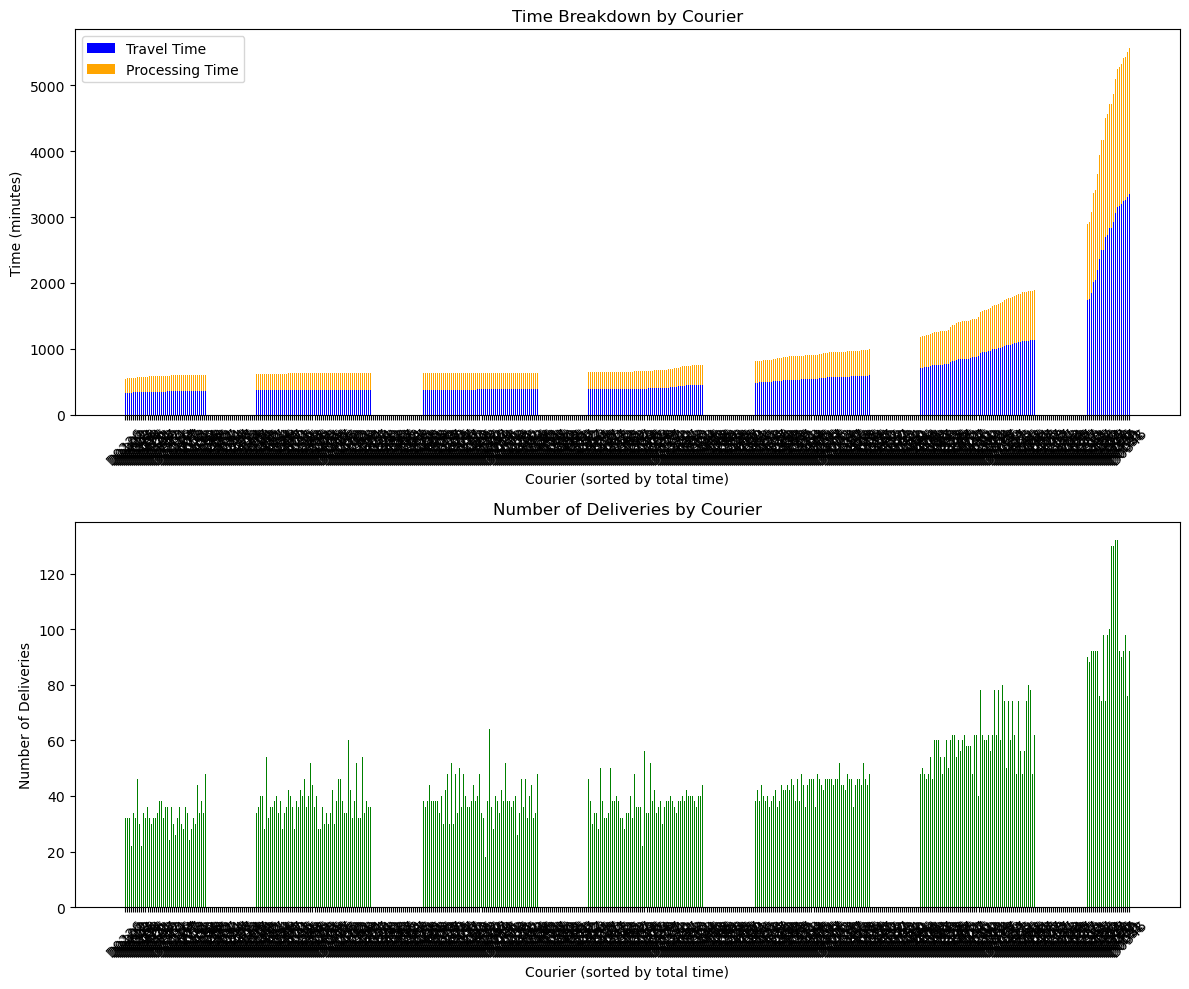

(<Figure size 1200x1000 with 2 Axes>,
 (<Axes: title={'center': 'Time Breakdown by Courier'}, xlabel='Courier (sorted by total time)', ylabel='Time (minutes)'>,
  <Axes: title={'center': 'Number of Deliveries by Courier'}, xlabel='Courier (sorted by total time)', ylabel='Number of Deliveries'>))

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_solution_metrics(solution_csv, filename="solution_metrics.png"):
    """
    Plot metrics about the solution from a CSV file. 
    Two bar charts to analyze courier performance.
    
    Args:
        solution_csv: Path to the solution CSV file.
        filename: Output filename for the plot.
    """
    # Load solution CSV
    df = pd.read_csv(solution_csv)

    # Extract metrics
    courier_ids = df["Courier_id"].unique()
    total_times = []
    travel_times = []
    processing_times = []
    num_events = []

    for courier_id in courier_ids:
        courier_df = df[df["Courier_id"] == courier_id]

        # Compute total, travel, and processing times
        total_time = courier_df["Departure_time"].max() - courier_df["Arrival_time"].min()
        travel_time = total_time * 0.6  # Assuming 60% of time is travel
        processing_time = total_time * 0.4  # Assuming 40% of time is processing

        total_times.append(total_time)
        travel_times.append(travel_time)
        processing_times.append(processing_time)
        num_events.append(len(courier_df))

    # Sort by total time
    sorted_indices = np.argsort(total_times)
    courier_ids = [courier_ids[i] for i in sorted_indices]
    total_times = [total_times[i] for i in sorted_indices]
    travel_times = [travel_times[i] for i in sorted_indices]
    processing_times = [processing_times[i] for i in sorted_indices]
    num_events = [num_events[i] for i in sorted_indices]

    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot time breakdown
    indices = np.arange(len(courier_ids))
    width = 0.35

    ax1.bar(indices, travel_times, width, label="Travel Time", color="blue")
    ax1.bar(indices, processing_times, width, bottom=travel_times, label="Processing Time", color="orange")

    ax1.set_xlabel("Courier (sorted by total time)")
    ax1.set_ylabel("Time (minutes)")
    ax1.set_title("Time Breakdown by Courier")
    ax1.set_xticks(indices)
    ax1.set_xticklabels(courier_ids, rotation=45)
    ax1.legend()

    # Plot number of events
    ax2.bar(indices, num_events, width, color="green")
    ax2.set_xlabel("Courier (sorted by total time)")
    ax2.set_ylabel("Number of Deliveries")
    ax2.set_title("Number of Deliveries by Courier")
    ax2.set_xticks(indices)
    ax2.set_xticklabels(courier_ids, rotation=45)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

    return fig, (ax1, ax2)

# Example usage
plot_solution_metrics("solution.csv")
